In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from PIL import Image
import os

In [3]:
# 1. Feature Extraction Function

def image_to_feature_vector(image_path):
    image = Image.open(image_path)
    # Resize the image to match training data dimensions
    image = image.resize((70, 70))  # Assuming training images were 70x70
    image_array = np.array(image)
    feature_vector = image_array.flatten()
    return feature_vector

In [4]:
# 2. Label Mapping
label_mapping = {'triangle': 0, 'rectangle': 1, 'ellipse': 2, 'other': 3}

def map_labels_to_int(labels, label_mapping):
    return np.array([label_mapping[label] for label in labels])


In [5]:
# 3. Data Loading Function
def load_image_data(folder_path):
    image_data = []
    labels = []
    for dirname, foldername, filenames in os.walk(folder_path):
        for filename in filenames:
            # Check if the file is a PNG image and the name (without extension) is in label_mapping
            if filename.endswith(".png") and filename.split(".")[0] in label_mapping:
                image_path = os.path.join(dirname, filename)

                # Attempt to load the image
                try:
                    feature_vector = image_to_feature_vector(image_path)
                    label = filename.split(".")[0]
                    image_data.append(feature_vector)
                    labels.append(label_mapping[label])
                except Exception as e:
                    # Print an error message if image loading fails
                    print(f"Error loading image {image_path}: {e}")

    # Check if any images were loaded, print a warning if not
    if not image_data:
        print("Warning: No images were loaded. Check the folder path and image names.")

    return np.array(image_data), np.array(labels)


In [6]:
# 4. Shape Prediction Function (Modified)
def predict_shape(image_path, knn_model):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shape_name = ""
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        perimeter = cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, 0.04 * perimeter, True)

        if len(approx) == 3:
            shape_name = "triangle"
        elif len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = float(w) / h
            if 0.8 <= aspect_ratio <= 1.2:
                shape_name = "square"  # Consider as square
            else:
                shape_name = "rectangle"
        elif len(approx) >= 6:  # Potential circle or ellipse
            # Calculate circularity to distinguish between circle and ellipse
            area = cv2.contourArea(largest_contour)
            circularity = 4 * np.pi * (area / (perimeter ** 2))

            if 0.8 <= circularity <= 1.2:  # Adjust threshold as needed
                shape_name = "circle"
            else:
                shape_name = "ellipse"

        return shape_name

    else:
        # KNN fallback (Modified)
        feature_vector = image_to_feature_vector(image_path)
        feature_vector = feature_vector.reshape(1, -1)
        predicted_label = knn_model.predict(feature_vector)[0]

        # Handle unknown labels
        if 0 <= predicted_label <= 3:
            shape_name = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_label)]
        else:
            shape_name = "other"

        return shape_name

In [7]:
# 5. Main Execution
# Load and split data
X, y = load_image_data('/content/drive/MyDrive/Electives_Final/archive/data')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
# Train KNN model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

Accuracy: 0.9653846153846154
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       161
           1       0.97      0.98      0.97       173
           2       0.92      0.98      0.95       169
           3       0.99      0.94      0.96       277

    accuracy                           0.97       780
   macro avg       0.96      0.97      0.97       780
weighted avg       0.97      0.97      0.97       780



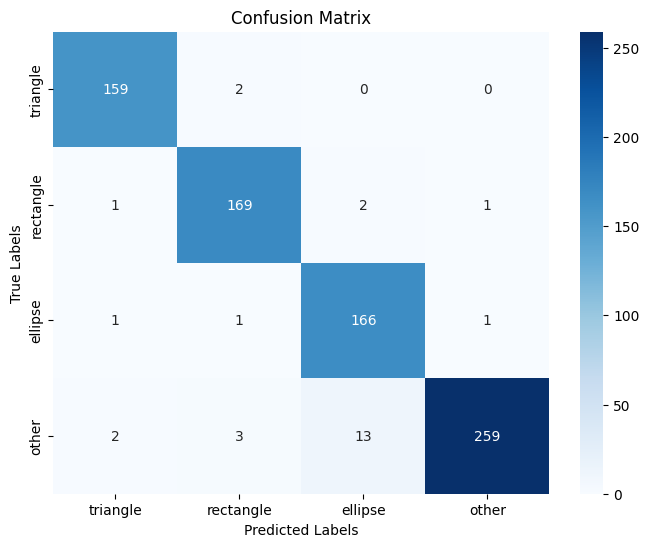

In [9]:
# Evaluate the model
y_pred = knn.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate a classification report
print(metrics.classification_report(y_test, y_pred))

#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label_mapping.keys()),
            yticklabels=list(label_mapping.keys()))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

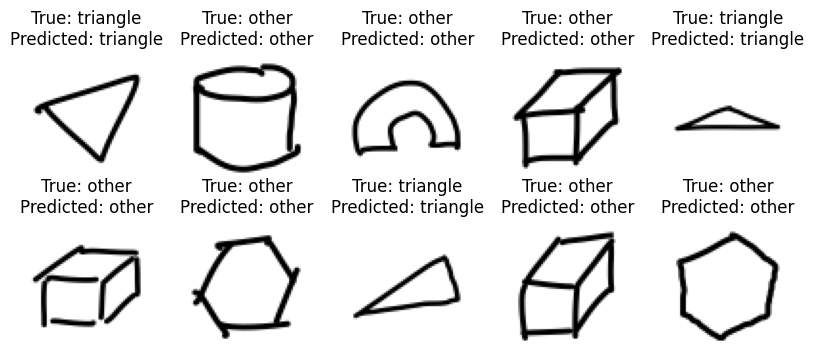

In [10]:
label_mapping = {0: 'triangle', 1: 'rectangle', 2: 'ellipse', 3: 'other'} # Updated for inverse mapping

# Display some images and predictions
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(70, 70, 4), cmap='gray')

    # Get shape names for labels
    true_label = label_mapping[y_test[i]]
    predicted_label = label_mapping[y_pred[i]]

    # Set title with true above predicted
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")
    ax.axis('off')

plt.show()

Saving OIP (2).jpg to OIP (2) (3).jpg
User uploaded file "OIP (2) (3).jpg" with length 8964 bytes
Predicted shape for OIP (2) (3).jpg: ellipse


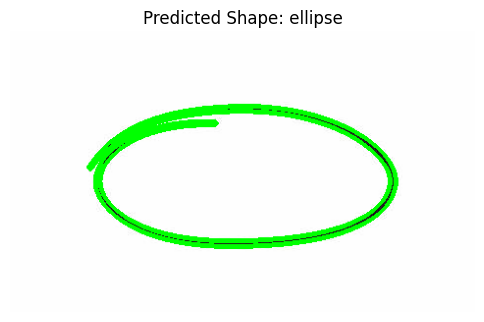

In [26]:

import os
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  # Predict the shape of the uploaded image
  predicted_shape = predict_shape(fn, knn)  # Assuming 'knn' is your trained model
  print(f"Predicted shape for {fn}: {predicted_shape}")

  # Display the image and draw contours
  img = cv2.imread(fn)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    cv2.drawContours(img, [largest_contour], -1, (0, 255, 0), 3)  # Draw green contour

  plt.figure(figsize=(6, 6))
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for matplotlib
  plt.title(f"Predicted Shape: {predicted_shape}")
  plt.axis('off')
  plt.show()